# Brownian Motion

Two tasks: 
* What's the volatility of each node? (graph independent)
* What's the natural frequency of each node? (graph dependent)

Create simulation

In [36]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures

# Simulation parameters
num_nodes = 100
dim = 2
time_horizon = 10
dt = 1e-2
num_time_steps = int(time_horizon / dt)
beta_gain = 5
sigma_gain = 1

def run_simultion(simulation_seed=1,target_seed=29,graph_seed=31,independent=False):

    def kuramoto(graph, theta, omega, dt):
        deg = dict(graph.degree())
        dtheta = np.zeros_like(theta)
        for u, v, data in graph.edges(data=True):
            coupling = data['weight']
            dtheta[u] += dt * (omega[u] + (1/deg[u]) * coupling * np.sin(theta[v] - theta[u]))
            dtheta[v] += dt * (omega[v] + (1/deg[v]) * coupling * np.sin(theta[u] - theta[v]))
        return theta + dtheta

    def periodic_drift(beta, theta, omega,mu_0, t):
        return mu_0 + beta*np.sin(omega*t + theta)

    # Create a graph

    graph = nx.erdos_renyi_graph(n=num_nodes,p=np.log(num_nodes)/num_nodes+0.01,seed=graph_seed)
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = np.random.rand()

    # Nature frequency (target variable)
    np.random.seed(target_seed)
    natural_freq = np.random.rand(num_nodes)
    
    # Othe oscilator perameters
    np.random.seed(simulation_seed)
    omega = np.stack(dim*[natural_freq],axis=1)  # Intrinsic frequencies
    theta = 2 * np.pi * np.random.rand(num_nodes,dim)  # Initial phases
    beta =  beta_gain * np.ones((num_nodes,dim)) # amplitude
    mu_initial = np.random.rand(num_nodes,dim) # initial drift

    # brownian motion parameters
    X = np.random.rand(num_nodes,dim) # signal
    drift = np.random.rand(num_nodes,dim) # drift
    sigma = sigma_gain * np.eye(dim) # diffusion matrix

    # Simulate
    theta_traj = np.zeros((num_nodes,num_time_steps,dim))
    mu_traj = np.zeros((num_nodes,num_time_steps,dim))
    X_traj = np.zeros((num_nodes,num_time_steps, dim))

    # Time sequence
    tt = np.linspace(0, time_horizon, num_time_steps)

    for step,t in enumerate(tt):
        theta_traj[:, step] = theta
        mu_traj[:,step] = drift
        X_traj[:,step,:] = X
        theta = kuramoto(graph, theta, omega,dt)
        drift = periodic_drift(beta, theta,omega, mu_initial, t)
        X = X + dt * drift + np.sqrt(dt) * np.random.randn(num_nodes,dim) @ sigma

    return X_traj, natural_freq, graph

def get_sequence(X_traj,natural_freq,graph):
    snapshot_count = X_traj.shape[1]
    df_edge = nx.to_pandas_edgelist(graph.to_directed())
    edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
    edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
    snapshot_count = X_traj.shape[1]
    features = [ X_traj[:,t,:] for t in range(snapshot_count)]
    targets = [ torch.tensor(natural_freq,dtype=torch.float).unsqueeze(-1) for _ in range(snapshot_count)]
    # Sequential Data
    return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


Make dataset consisting of multiple SDE trajectories

In [5]:
from tqdm import tqdm

num_runs = 1
seq_dataset = []
for run in tqdm(range(num_runs)):
    X_traj, natural_freq, graph = run_simultion(simulation_seed=29+run,target_seed=29+run,graph_seed=29+run)
    seq_dataset.append(get_sequence(X_traj,natural_freq,graph))

torch.save(seq_dataset,'datasets/brownian/brownian.pth')

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Plot trajectories

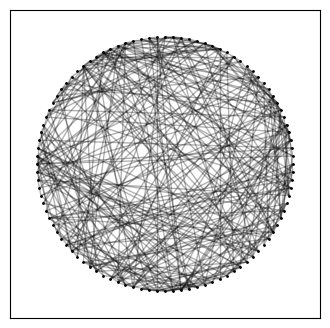

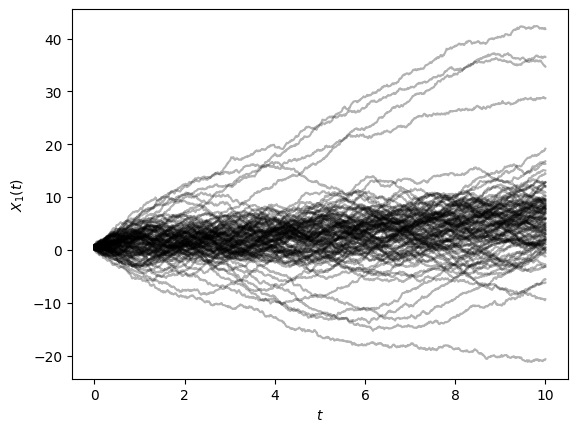

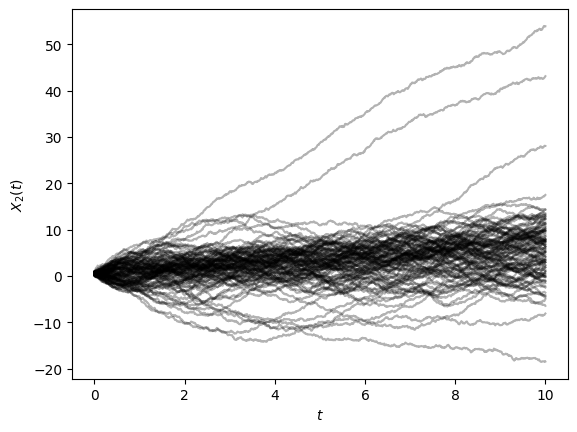

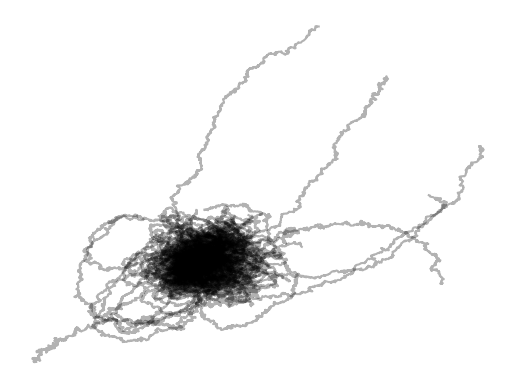

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# time vector
tt = np.linspace(0, time_horizon, num_time_steps)

# Plotting the graph
plt.figure(figsize=[4,4])
pos = nx.circular_layout(graph)
nx.draw_networkx_nodes(graph,pos,node_color='black',node_size=1)
nx.draw_networkx_edges(graph,pos,width=1,edge_color='black',alpha=0.3)

# Plot time series
for d in range(dim):
    plt.figure()
    for i in range(num_nodes):
        plt.plot(tt, X_traj[i,: , d],'black', label=f'Node {i}', alpha=0.3)
    plt.xlabel(f'$t$')
    plt.ylabel(f'$X_{d+1}(t)$')
    plt.show()

# Path XY
plt.figure()
for i in range(num_nodes):
    plt.plot(X_traj[i,: , 0], X_traj[i,: , 1],'black', label=f'Node {i}', alpha=0.3)
plt.xlabel(f'$X_1(t)$')
plt.ylabel(f'$X_2(t)$')
plt.axis('off')
plt.show()

Signature Feature Map + GNNs

Model: ChebNet4
Number of parameters: 855


100%|██████████| 40/40 [04:37<00:00,  6.93s/it]

MSE: 0.0330 ± 0.0292, MAE: 0.1400 ± 0.0646 


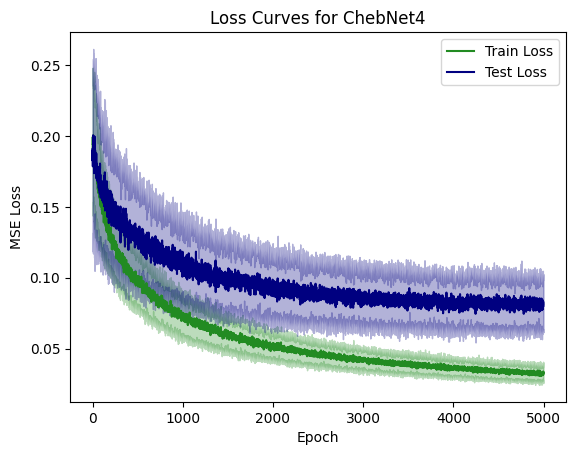

Model: ChebNet6
Number of parameters: 1275


100%|██████████| 40/40 [06:17<00:00,  9.43s/it]

MSE: 0.0279 ± 0.0345, MAE: 0.1149 ± 0.0721 


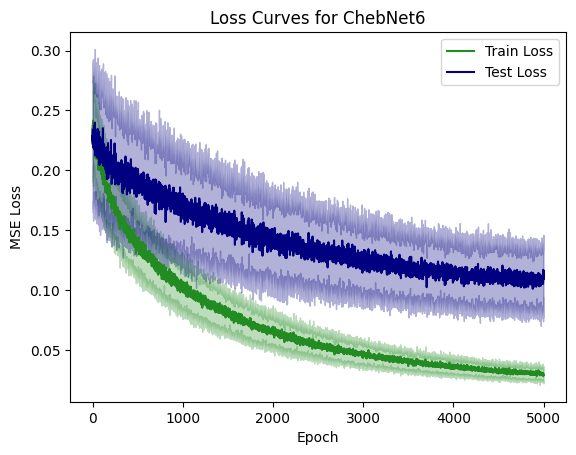

Model: ChebNet8
Number of parameters: 1695


100%|██████████| 40/40 [08:22<00:00, 12.55s/it]

MSE: 0.0314 ± 0.0468, MAE: 0.1064 ± 0.0952 


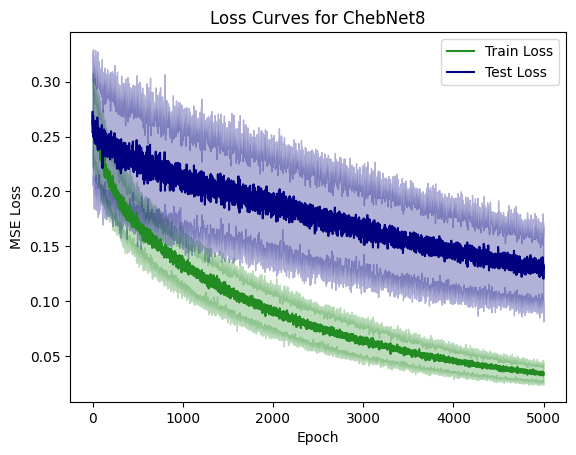

Model: MLPRegression
Number of parameters: 225


100%|██████████| 40/40 [00:56<00:00,  1.42s/it]

MSE: 0.0459 ± 0.0243, MAE: 0.1724 ± 0.0449 


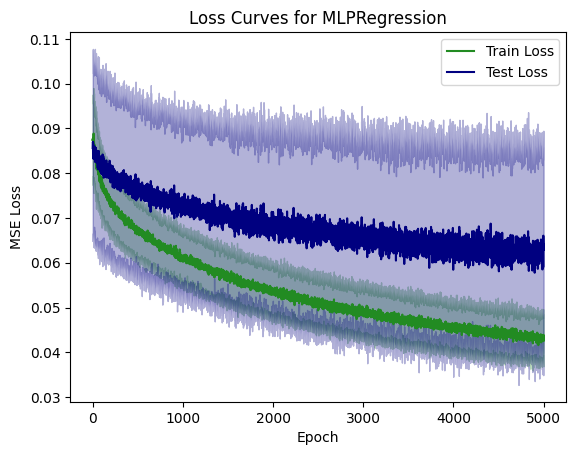

In [34]:
import torch
import torch.nn as nn
from pygsig.models import GCNRegression, MLPRegression, ChebNetRegression
from pygsig
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures

signature_depth = 3

dataset = []
for seq in seq_dataset:
    signature_transform = SignatureFeatures(seq, sig_depth=signature_depth, normalize=True, log_signature=False)
    dataset.append(signature_transform(seq))

num_splits = 4
num_runs = len(dataset)
num_trials = 10
num_epochs = 5000

learning_rate = 1e-4

print_during_training = False

# initialize models
k_list = [4,6,8]
models = []
models += [ChebNetRegression(num_channels=[signatory.signature_channels(dim, depth=signature_depth), 14, 1], K=k) for k in k_list]
for model in models:
    model._get_name = lambda: f'ChebNet{model.K}'
models += [MLPRegression(num_channels=[signatory.signature_channels(dim, depth=signature_depth), 14, 1])]

mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # train and test losses
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    test_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=29)
        for split in range(num_splits):
            for run, data in enumerate(dataset):
                # create splits
                train_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                test_mask[test_indices] = True
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            test_loss = criterion(out[test_mask], data.y[test_mask])

                        train_losses[split, run, trial, epoch] = train_loss.item()
                        test_losses[split, run, trial, epoch] = test_loss.item()

                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {test_loss.item():.4f}')
                    pbar.update(1)
                    
    # Error of best-performing model
    mse = []
    mae = []
    with torch.no_grad():
        for split in range(num_splits):
            mse_split = []
            mae_split = []
            for run,data in enumerate(dataset):
                # create splits
                train_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                test_mask[test_indices] = True
                mse_trial = []
                mae_trial = []
                for trial in range(num_trials):
                    out = model(data.x, data.edge_index)
                    mse_trial.append( mean_squared_error(data.y[test_mask],out[test_mask]) )
                    mae_trial.append( mean_absolute_error(data.y[test_mask],out[test_mask]) )
                mse_split.append(min(mse_trial))
                mae_split.append(min(mae_trial))
            mse.append(np.mean(mse_split))
            mae.append(np.mean(mae_split))
    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_models.append(mse)
    mae_models.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_test_losses = np.mean(test_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_test_losses = np.std(test_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='forestgreen')
    plt.plot(avg_test_losses,  label='Test Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.3, color='forestgreen')
    plt.fill_between(range(num_epochs), avg_test_losses - std_test_losses, avg_test_losses + std_test_losses, alpha=0.3,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()

In [40]:
mse_models

[]

Baseline

In [35]:
mse_base = []
mae_base = []
with torch.no_grad():
    for split in range(num_splits):
            # create splits
        train_indices, test_indices = splits[split]
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        for run,data in enumerate(dataset):
            for trial in range(num_trials):
                # Baseline
                out = torch.mean(data.y[train_mask]).item() * torch.ones(data.num_nodes)
                mse_base.append( mean_squared_error(data.y[test_mask],out[test_mask]) )
                mae_base.append( mean_absolute_error(data.y[test_mask],out[test_mask]) )

print('Model: Baseline')
print(f'Number of prameters: {0}')
print(f'{np.mean(mse_base):.4f} ± {np.std(mse_base):.4f}, MAE: {np.mean(mae_base):.4f} ± {np.std(mae_base):.4f} ')  


Model: Baseline
Number of prameters: 0
0.0852 ± 0.0203, MAE: 0.2496 ± 0.0271 


Spatiotemporal GNNs

In [39]:
import torch
import torch.nn as nn
from pygsig.models import GConvGRURegression,GConvLSTMRegression
import signatory
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

signature_depth = 3

num_splits = 4
num_runs = len(dataset)
num_trials = 10
num_epochs = 5000

learning_rate = 1e-4

print_during_training = False

# initialize models
k_list = [4,6,8]
models = []
models += [ChebNetRegression(num_channels=[signatory.signature_channels(dim, depth=signature_depth), 14, 1], K=k) for k in k_list]
for model in models:
    model._get_name = lambda: f'ChebNet{model.K}'
models += [MLPRegression(num_channels=[signatory.signature_channels(dim, depth=signature_depth), 14, 1])]

k_list = [5,6,8]

seq_models = []
seq_gru_models = [GConvGRURegression(num_channels = [2,16,1],K=k) for k in k_list]
for model in seq_gru_models:
    model._get_name = lambda: f'GConvGRU{model.K}'

seq_lstm_models = []
seq_lstm_models +=[GConvLSTMRegression(num_channels = [2,16,1],K=k) for k in k_list]
for model in seq_lstm_models:
    model._get_name = lambda: f'GConvLSTM{model.K}'
models += seq_gru_models
models += seq_lstm_models


mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # train and test losses
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    test_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=29)
        for split in range(num_splits):
            for run, seq in enumerate(seq_dataset):
                # create splits
                train_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                test_mask[test_indices] = True
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        for t,snapshot in enumerate(seq):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(snapshot.x, snapshot.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                test_loss = criterion(out[test_mask], data.y[test_mask])

                            train_losses[split, run, trial, epoch,t] = train_loss.item()
                            test_losses[split, run, trial, epoch,t] = test_loss.item()

                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {test_loss.item():.4f}')
                    pbar.update(1)
                    
    # Error of best-performing model
    mse = []
    mae = []
    with torch.no_grad():
        for split in range(num_splits):
            mse_split = []
            mae_split = []
            for run,data in enumerate(dataset):
                # create splits
                train_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                test_mask[test_indices] = True
                mse_trial = []
                mae_trial = []
                for trial in range(num_trials):
                    mse_snapshot = []
                    mae_snapshot = []
                    for t,snapshot in enumerate(seq):
                        out = model(snapshot.x, snapshot.edge_index)
                        mse_snapshot.append( mean_squared_error(data.y[test_mask],out[test_mask]) )
                        mae_snapshot.append( mean_absolute_error(data.y[test_mask],out[test_mask]) )
                    mse_trial.append(min(mse_snapshot))
                    mae_trial.append(min(mae_snapshot))
                mse_split.append(min(mse_trial))
                mae_split.append(min(mae_trial))
            mse.append(np.mean(mse_split))
            mae.append(np.mean(mae_split))
    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_models.append(mse)
    mae_models.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2,3))
    avg_test_losses = np.mean(test_losses, axis=(0,1,2,3))
    std_train_losses = np.std(train_losses, axis=(0,1,2,3))
    std_test_losses = np.std(test_losses, axis=(0,1,2,3))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='forestgreen')
    plt.plot(avg_test_losses,  label='Test Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.3, color='forestgreen')
    plt.fill_between(range(num_epochs), avg_test_losses - std_test_losses, avg_test_losses + std_test_losses, alpha=0.3,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()

Model: ChebNet4
Number of parameters: 855


  0%|          | 0/40 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 14x14)

Analyse results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn theme
sns.set_theme(style="darkgrid")

# Rest of your code
model_names = [f'S-Cheb{k}' for k in k_list]+[f'S-GAT{h}' for h in h_list]+['S-MLP','Base']

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.boxplot(mse_list, ax=axes)
axes.set_ylabel('MSE', fontsize=10)  # Set the font size for the y-axis label
axes.set_xticklabels(model_names, fontsize=8)  # Set the font size for the x-axis tick labels
fig.suptitle('Error Predicting Natural Frequencies')
plt.show()
